In [1]:
#%pip install tensorflow

In [2]:
import tensorflow as tf

def create_regression_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

### Data Collection. 
The dataset includes detailed information on resale transactions of HDB flats between January 1, 2017, and March 30, 2024. The dataset contains 180,154 rows and 11 columns and was downloaded on May 23, 2024. 

**Dataset URL**: [HDB Resale Prices](https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view) 

### Feature Engineering 
2024 Q1 == > 183.7
https://www.hdb.gov.sg/residential/selling-a-flat/overview/resale-statistics

(180154, 11) (175672, 15) (175672, 52)


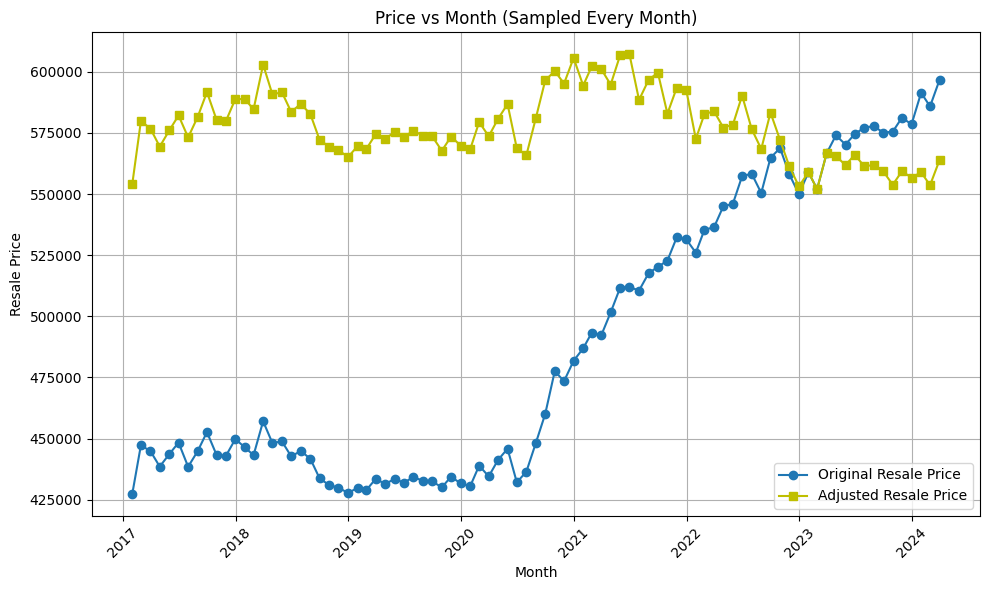

In [4]:
import pandas as pd
import data_config as cfg

df_raw = pd.read_csv('../data/SGHDB2017-2024.csv')
cfg.save_dataset_info(df_raw, fname='dataset_info.csv')

df = cfg.adjust_resale_price(df_raw, cut_off_date='2024-04-01')
cfg.visualize_adjusted_price(df[['month', 'resale_price', 'adjusted_price']].copy(), fname='adjusted_price.png')

df_clean = cfg.preprocess_data(df)
print(df_raw.shape, df.shape, df_clean.shape)

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into 30% and 70%
train_data, test_data = train_test_split(df_clean, test_size=0.3, random_state=42)

# Verify the shapes of the split data
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (122970, 52)
Test data shape: (52702, 52)


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Define the model architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(51,)),  # Input layer with 51 features
    keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 units
    keras.layers.Dense(1)  # Output layer with 1 unit
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=32)